In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratikpattanaik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import MinMaxScaler

class DataPrep():
    def __init__(self):
        self.trait_cat_dict = {
            'O': 'cOPN',
            'C': 'cCON',
            'E': 'cEXT',
            'A': 'cAGR',
            'N': 'cNEU',
            'OPN': 'cOPN',
            'CON': 'cCON',
            'EXT': 'cEXT',
            'AGR': 'cAGR',
            'NEU': 'cNEU',
            'Openness': 'cOPN',
            'Conscientiousness': 'cCON',
            'Extraversion': 'cEXT',
            'Agreeableness': 'cAGR',
            'Neuroticism': 'cNEU'
            }
        self.trait_score_dict = {
            'O': 'sOPN',
            'C': 'sCON',
            'E': 'sEXT',
            'A': 'sAGR',
            'N': 'sNEU',
            'OPN': 'sOPN',
            'CON': 'sCON',
            'EXT': 'sEXT',
            'AGR': 'sAGR',
            'NEU': 'sNEU',
            'Openness': 'sOPN',
            'Conscientiousness': 'sCON',
            'Extraversion': 'sEXT',
            'Agreeableness': 'sAGR',
            'Neuroticism': 'sNEU'
            }

    def prep_data(self, type, trait, regression=False, model_comparison=False):
        df_tweet = self.prep_status_data()

        tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

        if type == 'tweet':
#             X = tfidf.fit_transform(df_tweet['TWEET']).todense()

            X = df_tweet['TWEET']

#             if regression:
#                 y_column = self.trait_score_dict[trait]
#             else:
            y_column = self.trait_cat_dict[trait]
            y = df_tweet[y_column]

        return X, y


    def prep_status_data(self):
        df = pd.read_csv('mypersonality_final.csv', encoding="ISO-8859-1")
        df.rename(columns = {'STATUS':'TWEET'}, inplace = True)
        
        print(df['TWEET'])
        print('\n\n\n')
        
        for i in range(0, len(df['TWEET'])):
            df_tweets = re.sub('[^a-zA-Z]', ' ', df['TWEET'][i])
            df_tweets = df_tweets.lower()
            df_tweets = df_tweets.split()
            ps = PorterStemmer()
            all_stopwords = stopwords.words('english')
            all_stopwords.remove('not')
            df_tweets = [ps.stem(word) for word in df_tweets if not word in set(all_stopwords)]
            df['TWEET'][i] = ' '.join(df_tweets)
            corpus.append(df_tweets)
        
#         df['TWEET'] = df.groupby(['#AUTHID'])['TWEET'].transform(lambda x : ' '.join(x))
        other_features_columns = [
                'NETWORKSIZE',
                'BETWEENNESS',
                'NBETWEENNESS',
                'DENSITY',
                'BROKERAGE',
                'NBROKERAGE',
                'TRANSITIVITY',
                'DATE',
                '#AUTHID'
            ]
        df.drop(other_features_columns, axis=1, inplace=True)
        df.drop_duplicates(inplace=True)
        
        df = self.convert_traits_to_boolean(df)
        
        print(df['TWEET'])
        return df


    def convert_traits_to_boolean(self, df):
        trait_columns = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']
        d = {'y': True, 'n': False}

        for trait in trait_columns:
            df[trait] = df[trait].map(d)

        return df


    def load_data(self, filepath):
        return pd.read_csv(filepath, encoding="ISO-8859-1")
    


In [7]:
class Model():
    def __init__(self):
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)

        self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)

        return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)

        return self.rfc.predict_proba(X)*100

if __name__ == '__main__':
    traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
    model = Model()

    for trait in traits:
        dp = DataPrep()
        X_categorical, y_categorical = dp.prep_data('tweet', trait, regression=False, model_comparison=False)

        print('Fitting ' + trait + ' Model')
        model.fit(X_categorical, y_categorical, regression=False)
        print('----Fitting Completed----')
        
        with open('static/' + trait + '_model.pkl', 'wb') as f:
            # Write the model to a file.
            pickle.dump(model, f)

0                             likes the sound of thunder.
1       is so sleepy it's not even funny that's she ca...
2       is sore and wants the knot of muscles at the b...
3              likes how the day sounds in this new song.
4                                             is home. <3
                              ...                        
9912                         little things give you away.
9913                          is wishing it was Saturday.
9914                      is studying hard for the G.R.E.
9915                                snipers get more head
9916    Last night was amazing! Not only did I see *PR...
Name: TWEET, Length: 9917, dtype: object




0                                      like sound thunder
1                         sleepi not even funni get sleep
2       sore want knot muscl base neck stop hurt hand ...
3                                 like day sound new song
4                                                    home
                           

In [8]:
import tweepy
import configparser
import pandas as pd
import re

def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    return tweet

def fetch_tweets(username):
    # read configs
    config = configparser.ConfigParser()
    config.read('config.ini')

    api_key = config['twitter']['api_key']
    api_key_secret = config['twitter']['api_key_secret']

    access_token = config['twitter']['access_token']
    access_token_secret = config['twitter']['access_token_secret']
    bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJCXiAEAAAAAlMOQc2O%2BbZib8Uw2sld4MLomM0E%3D4ePyxuoasHqc5YPP4NKRz6YwfYCbVVepKa1bh4pG3ljJiN4daS'
    #Put your Bearer Token in the parenthesis below
    client = tweepy.Client(bearer_token)
    
    query = 'from:'+ username + ' -is:retweet lang:en'
    tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                                  tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1000)


    columns = ['TWEETS']
    data = []

    for tweet in tweets:
        data.append(tweet.text)
    
    

    df_pred = pd.DataFrame(data, columns = columns)
    df_pred = df_pred.replace("\s+", " ", regex=True).apply(lambda x: x.str.strip())

    print(df_pred['TWEETS'])
    print('\n\n\n')
    df_pred['TWEETS'] = df_pred['TWEETS'].apply(remove_usernames_links)
    print(df_pred['TWEETS'])
    for i in range(0, len(df_pred['TWEETS'])):
        df_tweets = re.sub('[^a-zA-Z]', ' ', df_pred['TWEETS'][i])
        df_tweets = df_tweets.lower()
        df_tweets = df_tweets.split()
        ps = PorterStemmer()
        all_stopwords = stopwords.words('english')
        all_stopwords.remove('not')
        df_tweets = [ps.stem(word) for word in df_tweets if not word in set(all_stopwords)]
#         df_pred['TWEETS'][i] = ' '.join(df_tweets)
        corpus.append(df_tweets)
    

    return df_pred

    

In [9]:
class Predictor():
    def __init__(self):

        self.traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
        self.models = {}
        self.load_models()
        
    def load_models(self):
        M = Model()
        for trait in self.traits:
            with open('static/' + trait + '_model.pkl', 'rb') as f:
                self.models[trait] = pickle.load(f)

    def predict(self, X, traits='All', predictions='All'):
        predictions = {}
        if traits == 'All':
            for trait in self.traits:
                pkl_model = self.models[trait]


                trait_categories = pkl_model.predict(X, regression=False)
                predictions['pred_c'+trait] = str(trait_categories[0])


                trait_categories_probs = pkl_model.predict_proba(X)
                predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1][0]

        return predictions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
 

def bar_plot(y_pred, title=""):
    # creating the dataset
    data = {'Openness': y_pred['pred_prob_cOPN'], 'Conscientiousness': y_pred['pred_prob_cCON'], 'Aggreableness': y_pred['pred_prob_cAGR'], 'Extraversion': y_pred['pred_prob_cEXT'], 'Neuroticism': y_pred['pred_prob_cNEU']}
    traits = list(data.keys())
    values = list(data.values())

    x = np.arange(len(traits)) # the label locations
    width = 0.35 # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_ylabel('Percentage')
    ax.set_xlabel('Traits')
    ax.set_title("Personality Prediction for @" + title)
    ax.set_xticks(x)
    ax.set_xticklabels(traits)
    ax.set_ylim([0 ,100])

    pps = ax.bar(x, values, width, label='traits', color='maroon')
    for p in pps:
       height = p.get_height()
       ax.annotate('{0:.5g}%'.format(height),
          xy=(p.get_x() + p.get_width() / 2, height),
          xytext=(0, 5), # 3 points vertical offset
          textcoords="offset points",
          ha='center', va='bottom')

    plt.show()
    
def multi_bar_plot(y_pred1, y_pred2, title1, title2):
    data1 = {'Openness': y_pred1['pred_prob_cOPN'], 'Conscientiousness': y_pred1['pred_prob_cCON'], 'Aggreableness': y_pred1['pred_prob_cAGR'], 'Extraversion': y_pred1['pred_prob_cEXT'], 'Neuroticism': y_pred1['pred_prob_cNEU']}
    data2 = {'Openness': y_pred2['pred_prob_cOPN'], 'Conscientiousness': y_pred2['pred_prob_cCON'], 'Aggreableness': y_pred2['pred_prob_cAGR'], 'Extraversion': y_pred2['pred_prob_cEXT'], 'Neuroticism': y_pred2['pred_prob_cNEU']}

    
    traits = list(data1.keys())
    values = list(data1.values()).copy()
    
    values2 = list(data2.values()).copy()

    x = np.arange(len(traits))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.bar(x - width/2, values, width, label=title1, color='royalblue')
    rects2 = ax.bar(x + width/2, values2, width, label=title2, color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Traits')
    ax.set_title("Personality Comparision of @"+title1+" and @"+title2)
    ax.set_xticks(x, traits)
    ax.set_ylim([0, 100])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
 
# traits = ["Openness", "Conscientiousness", "Agreeableness", "Extraversion", "Neuroticism"]

# data = {'Openness': y_pred['pred_prob_cOPN'], 'Conscientiousness': y_pred['pred_prob_cCON'], 'Aggreableness': y_pred['pred_prob_cAGR'], 'Extraversion': y_pred['pred_prob_cEXT'], 'Neuroticism': y_pred['pred_prob_cNEU']}
# actual = list(data.keys())
# expected = list(data.values())
def radial_plot(y_pred, title=""):
    data = {'Openness': y_pred['pred_prob_cOPN'], 'Conscientiousness': y_pred['pred_prob_cCON'], 'Aggreableness': y_pred['pred_prob_cAGR'], 'Extraversion': y_pred['pred_prob_cEXT'], 'Neuroticism': y_pred['pred_prob_cNEU']}
    traits = list(data.keys())
    values = list(data.values()).copy()
    values.append(values[0])


    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(8, 4))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2*np.pi, len(values), endpoint=True)

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(traits))), (traits))

    # Plot actual sales graph
    # plt.plot(theta, actual)

    # Plot expected sales graph
    plt.plot(theta, values, label = title)
    plt.fill(theta, values, 'b', alpha=0.1)
    plt.ylim(0, 100)

    # Add legend and title for the plot
    plt.legend(loc=1)
    plt.title("Personality Prediction for @" + title)

    # Dsiplay the plot on the screen
    plt.show()
    
def radial_plot_comparision(y_pred1, y_pred2, title1, title2):
 
    data1 = {'Openness': y_pred1['pred_prob_cOPN'], 'Conscientiousness': y_pred1['pred_prob_cCON'], 'Aggreableness': y_pred1['pred_prob_cAGR'], 'Extraversion': y_pred1['pred_prob_cEXT'], 'Neuroticism': y_pred1['pred_prob_cNEU']}
    data2 = {'Openness': y_pred2['pred_prob_cOPN'], 'Conscientiousness': y_pred2['pred_prob_cCON'], 'Aggreableness': y_pred2['pred_prob_cAGR'], 'Extraversion': y_pred2['pred_prob_cEXT'], 'Neuroticism': y_pred2['pred_prob_cNEU']}

    
    traits = list(data1.keys())
    values = list(data1.values()).copy()
    values.append(values[0])
    
    values2 = list(data2.values()).copy()
    values2.append(values2[0])

    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(8, 4))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2 * np.pi, len(values))

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(traits))), (traits))

    # Plot actual sales graph
    plt.plot(theta, values, label=title1)
    plt.fill(theta, values, 'blue', alpha=0.1)

    # Plot expected sales graph
    plt.plot(theta, values2, label=title2)
    plt.fill(theta, values2, 'orange', alpha=0.1)

    # Add legend and title for the plot
    plt.legend(loc=1)
    plt.title("Personality Comparision of @"+title1+" and @"+title2)

    plt.ylim(0 ,100)
    # Dsiplay the plot on the screen
    plt.show()

In [12]:
def find_personality():
    P = Predictor()
    username = str(input('enter username: '))
    print('\n\n')
    X_pred = fetch_tweets(username)['TWEETS']

    y_pred = P.predict(list(X_pred))

    y1 = pd.DataFrame(y_pred.items(), columns = ['Traits Score Fields', 'Scores'])
#     print(y1)

    bar_plot(y_pred, title = username)
    radial_plot(y_pred, title = username)
    
    return y_pred, username
    
def compare():
    
    y_pred1, username1 = find_personality()
    y_pred2, username2 = find_personality()
    
    radial_plot_comparision(y_pred1, y_pred2, username1, username2)
    multi_bar_plot(y_pred1, y_pred2, username1, username2)
    
    return y_pred1, y_pred2, username1, username2

enter username: elonmusk



0     @CatherinScience I must admit to being congeni...
1     One day, Starship will take us to Mars https:/...
2     Team turned off 1 engine just before start &am...
3     Attempting Starship 33 engine static fire http...
4     @WholeMarsBlog Too many journalists want to sh...
                            ...                        
94    @cb_doge @mayemusk @Tesla @Twitter More to com...
95    @firesideint Twitter’s legacy Blue Verified is...
96    To be eligible, the account must be a subscrib...
97    Starting today, Twitter will share ad revenue ...
98    @PepitoTheCat @BillyM2k @ericnakagawa I guess ...
Name: TWEETS, Length: 99, dtype: object




0      I must admit to being congenitally optimistic...
1               One day, Starship will take us to Mars 
2     Team turned off 1 engine just before start &am...
3            Attempting Starship 33 engine static fire 
4      Too many journalists want to shape your opini...
                            ... 

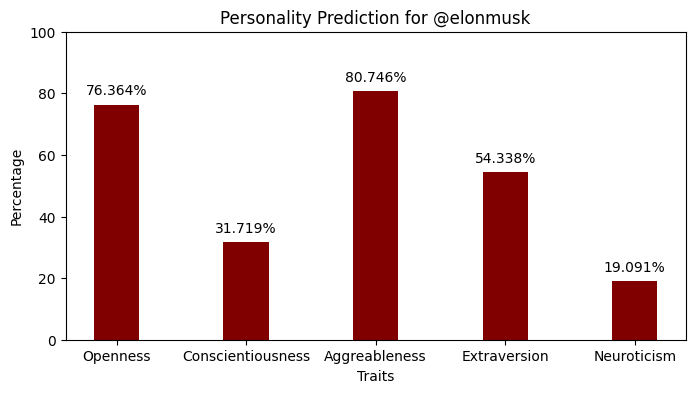

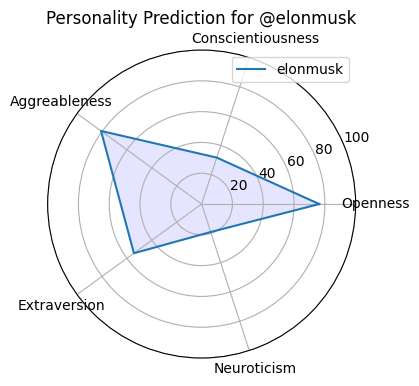

In [14]:
if __name__ == '__main__':
#     y1, y2, u1, u2 = compare()
    y1, y2 = find_personality()
#     y1 = pd.DataFrame(y1.items(), columns = ['Traits Score', 'Values'])
#     y2 = pd.DataFrame(y2.items(), columns = ['Traits Score', 'Values'])
    
    
    
#     print(y1)
#     print(y2)